In [1]:
# !pip install torchinfo
import os
import pandas as pd
import numpy as np
import cv2
from torchvision.io import read_image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, random_split, DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from torchvision.transforms import ToTensor
from PIL import Image
import os
# from torchsummary import summary
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision 
from torchvision import transforms
from torchinfo import summary
import timm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class Bkaineoprocess(Dataset):
    def __init__(self, img_dir, label_dir, resize=None, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.resize = resize
        self.transform = transform
        self.images = os.listdir(self.img_dir)
    def read_and_resize_image(self,image_path, resize):
        image = Image.open(image_path).convert('RGB')
        image = image.resize(resize)
        return np.array(image)

    def rgb_to_hsv(self,image):
        # Convert RGB to HSV using OpenCV
        return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    def create_mask(self,image, lower_bound, upper_bound):
        lower_bound = torch.tensor(lower_bound, dtype=torch.float32)
        upper_bound = torch.tensor(upper_bound, dtype=torch.float32)
        mask = (image >= lower_bound) & (image <= upper_bound)
        return mask.all(dim=-1).int()

    def process_image(self,image_path):
        image = self.read_and_resize_image(image_path, self.resize)
        image_hsv = torch.from_numpy(self.rgb_to_hsv(image))  # Convert to tensor after HSV conversion

        # Red color range
        lower1 = np.array([0, 100, 20])
        upper1 = np.array([10, 255, 255])
        lower2 = np.array([160, 100, 20])
        upper2 = np.array([179, 255, 255])

        red_mask1 = self.create_mask(image_hsv, lower1, upper1)
        red_mask2 = self.create_mask(image_hsv, lower2, upper2)
        red_mask = red_mask1 + red_mask2
        red_mask[red_mask != 0] = 1

        # Green color range
        green_mask = self.create_mask(image_hsv, np.array([36, 25, 25]), np.array([70, 255, 255]))
        green_mask[green_mask != 0] = 2

        full_mask = torch.max(red_mask, green_mask)
        full_mask = full_mask.unsqueeze(-1)
        full_mask = full_mask.type(torch.uint8)

        return full_mask
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx])
        image = cv2.imread(img_path)  
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        label = self.process_image(label_path) 
        image = cv2.resize(image, self.resize)
        if self.transform:
            image = self.transform(image)
        return image, label

    def show_image(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx])
        image = plt.imread(img_path)
        label = plt.imread(label_path)
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(image)
        axs[0].set_title('Image')
        axs[1].imshow(label)
        axs[1].set_title('Label')
        plt.show()

In [3]:
neo = Bkaineoprocess(img_dir= '/kaggle/input/bkai-igh-neopolyp/train/train',
                             label_dir= '/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt',
                             resize= (512,512),
                             transform = None)
images_data = []
labels_data = []
for x,y in neo:
    images_data.append(x)
    labels_data.append(y)

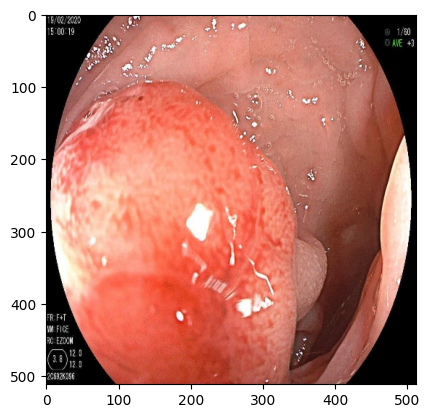

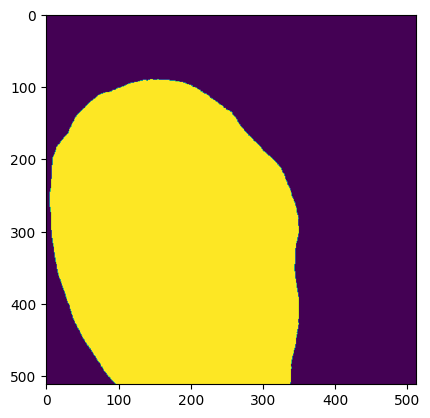

In [9]:
plt.imshow(images_data[4])
plt.show()
plt.imshow(labels_data[4])
plt.show()

In [10]:
!pip install -U albumentations[imgaug]

In [10]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

segmentation_transform = A.Compose([
    # Randomly crops the image and resizes it back to the original size
    A.RandomResizedCrop(height=512, width=512, scale=(0.8, 1.0), p=0.5),

    # Random horizontal flipping
    A.HorizontalFlip(p=0.5),

    # Random vertical flipping
    A.VerticalFlip(p=0.5),

    # Randomly changes the brightness, contrast, and saturation of an image
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02, p=0.5),

    # Randomly rotates the image
    A.Rotate(limit=30, p=0.5, border_mode=cv2.BORDER_CONSTANT),

    # Applies elastic transformations
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),

    # Normalizes the image
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),

    # Converts the image to a PyTorch tensor
    ToTensorV2(),
])


In [16]:
transformed = segmentation_transform(image=images_data[2], mask=labels_data[2].numpy())
image = transformed['image'].float()
label = transformed['mask'].float()
label = label.permute(2, 0, 1)

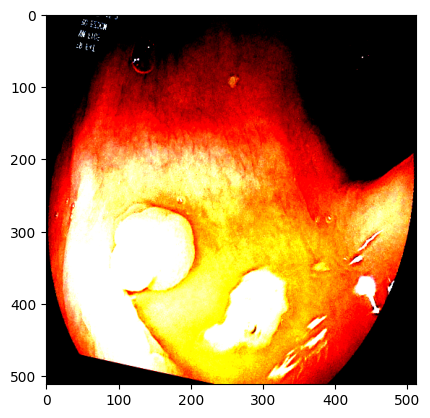

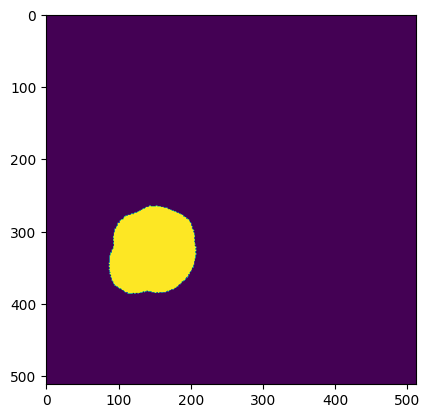

In [17]:
plt.imshow(image.permute(1, 2, 0))
plt.show()
plt.imshow(label.permute(1, 2, 0))
plt.show()

In [19]:
class Bkaineo(Bkaineoprocess):
    def __init__(self, data, targets, transform):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __getitem__(self, index):
        image = self.data[index]
        label = self.targets[index]
        if self.transform:
            transformed = self.transform(image=image, mask=label.numpy())
            image = transformed['image'].float()
            label = transformed['mask'].float()
            label = label.permute(2, 0, 1)
        return image, label
    def __len__(self):
        return len(self.data)


In [20]:
!pip install segmentation-models-pytorch



  Obtaining dependency information for segmentation-models-pytorch from https://files.pythonhosted.org/packages/cb/70/4aac1b240b399b108ce58029ae54bc14497e1bbc275dfab8fd3c84c1e35d/segmentation_models_pytorch-0.3.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for timm==0.9.2 from https://files.pythonhosted.org/packages/29/90/94f5deb8d76e24a89813aef95e8809ca8fd7414490428480eda19b133d4a/timm-0.9.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 7.6 MB/s eta 0:00:00
  Obtaining dependency information for munch from https://files.pythonhosted.org/packages/56/b3/7c69b37f03260a061883bec0e7b05be7117c1b1c85f5212c72c8c2bc3c8c/munch-4.0.0-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [21]:
import segmentation_models_pytorch as smp


model = smp.Unet(
    encoder_name="resnet34",        
    encoder_weights="imagenet",     
    in_channels=3,                  
    classes=3     
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 215MB/s] 


In [22]:
import wandb
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [23]:
config = {
    'batch_size' : 8,
    'lr': 0.0001,
    'num_epoch' : 50,
    'checkpoint_path' : 'best_model.pth',
    'train_ratio':0.8
}

In [24]:
train_size = int(config['train_ratio'] * len(images_data))
val_size = len(images_data) - train_size
train_dataset = Bkaineo(images_data[:train_size], labels_data[:train_size], transform=segmentation_transform)
val_dataset = Bkaineo(images_data[train_size:], labels_data[train_size:], transform=segmentation_transform)
optimizer = optim.Adam(model.parameters(), lr=config['lr'])
color_dict= {0: (0, 0, 0),
             1: (511, 0, 0),
             2: (0, 511, 0)}
def mask_to_rgb(mask, color_dict):
    output = np.zeros((mask.shape[0], mask.shape[1], 3))
#     print(output.shape)
    for k in color_dict.keys():
        output[mask==k] = color_dict[k]

    return np.uint8(output)    

In [26]:
from tqdm import tqdm
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
experiment = wandb.init(
    project="Unet",
    config={
    "learning_rate": 0.0001,
    "architecture": "Unet",
    "dataset": "bkai-neopolyp",
    "epochs": 20,
    }
)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
best_val_loss = 999
# Training loop
for epoch in range(config['num_epoch']):
    model.train()
    epoch_loss = 0
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.squeeze(dim=1).long()
        outputs = model(images)
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    experiment.log({'train loss': epoch_loss/len(train_loader),
                    'epoch': epoch}) 
    print(f"Epoch [{epoch+1}/{config['num_epoch']}], Train_Loss: {epoch_loss/len(train_loader):.10f}")
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            labels = labels.squeeze(dim=1).long()
            
            # Forward pass
            outputs = model(images)
#             print(outputs.shape)

            val_loss += criterion(outputs.float(),labels.long()).item()

    # Print the loss for this epoch
    print(f"Epoch [{epoch+1}/{config['num_epoch']}], Loss: {val_loss/len(val_loader):.10f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint = { 
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': val_loss,
        }
        torch.save(checkpoint, config['checkpoint_path'])
        print('Save new model to {}'.format(config['checkpoint_path']))

epoch,▁
train loss,▁
epoch,0
train loss,0.89059


100%|██████████| 100/100 [04:07<00:00,  2.47s/it]


Epoch [1/50], Train_Loss: 0.4534380355
Epoch [1/50], Loss: 0.3704339504
Save new model to best_model.pth


100%|██████████| 100/100 [03:58<00:00,  2.38s/it]


Epoch [2/50], Train_Loss: 0.3044152497
Epoch [2/50], Loss: 0.2605936486
Save new model to best_model.pth


100%|██████████| 100/100 [04:03<00:00,  2.43s/it]


Epoch [3/50], Train_Loss: 0.2139864911
Epoch [3/50], Loss: 0.2119679439
Save new model to best_model.pth


100%|██████████| 100/100 [04:20<00:00,  2.60s/it]


Epoch [4/50], Train_Loss: 0.1629389703
Epoch [4/50], Loss: 0.1875411958
Save new model to best_model.pth


100%|██████████| 100/100 [04:18<00:00,  2.59s/it]


Epoch [5/50], Train_Loss: 0.1359072989
Epoch [5/50], Loss: 0.1345511124
Save new model to best_model.pth


100%|██████████| 100/100 [04:08<00:00,  2.48s/it]


Epoch [6/50], Train_Loss: 0.1090929046
Epoch [6/50], Loss: 0.1137162653
Save new model to best_model.pth


100%|██████████| 100/100 [04:22<00:00,  2.62s/it]


Epoch [7/50], Train_Loss: 0.0978732468
Epoch [7/50], Loss: 0.1073774856
Save new model to best_model.pth


100%|██████████| 100/100 [04:11<00:00,  2.52s/it]


Epoch [8/50], Train_Loss: 0.0794000780
Epoch [8/50], Loss: 0.0879240309
Save new model to best_model.pth


100%|██████████| 100/100 [04:20<00:00,  2.61s/it]


Epoch [9/50], Train_Loss: 0.0675240375
Epoch [9/50], Loss: 0.0807286744
Save new model to best_model.pth


100%|██████████| 100/100 [04:23<00:00,  2.63s/it]


Epoch [10/50], Train_Loss: 0.0628953034
Epoch [10/50], Loss: 0.0808875668


100%|██████████| 100/100 [04:12<00:00,  2.53s/it]


Epoch [11/50], Train_Loss: 0.0582803734
Epoch [11/50], Loss: 0.0754400010
Save new model to best_model.pth


100%|██████████| 100/100 [04:20<00:00,  2.60s/it]


Epoch [12/50], Train_Loss: 0.0540546183
Epoch [12/50], Loss: 0.0713283074
Save new model to best_model.pth


100%|██████████| 100/100 [04:16<00:00,  2.57s/it]


Epoch [13/50], Train_Loss: 0.0556235785
Epoch [13/50], Loss: 0.0709484954
Save new model to best_model.pth


100%|██████████| 100/100 [04:14<00:00,  2.54s/it]


Epoch [14/50], Train_Loss: 0.0472042027
Epoch [14/50], Loss: 0.0754497030


100%|██████████| 100/100 [04:10<00:00,  2.51s/it]


Epoch [15/50], Train_Loss: 0.0496933797
Epoch [15/50], Loss: 0.0603120721
Save new model to best_model.pth


100%|██████████| 100/100 [04:12<00:00,  2.53s/it]


Epoch [16/50], Train_Loss: 0.0407798684
Epoch [16/50], Loss: 0.0685543064


100%|██████████| 100/100 [04:01<00:00,  2.41s/it]


Epoch [17/50], Train_Loss: 0.0443207850
Epoch [17/50], Loss: 0.0730927432


100%|██████████| 100/100 [04:24<00:00,  2.64s/it]


Epoch [18/50], Train_Loss: 0.0411905533
Epoch [18/50], Loss: 0.0663791607


100%|██████████| 100/100 [04:18<00:00,  2.58s/it]


Epoch [19/50], Train_Loss: 0.0430651401
Epoch [19/50], Loss: 0.0566699052
Save new model to best_model.pth


100%|██████████| 100/100 [04:30<00:00,  2.70s/it]


Epoch [20/50], Train_Loss: 0.0387106728
Epoch [20/50], Loss: 0.0661001414


100%|██████████| 100/100 [04:20<00:00,  2.60s/it]


Epoch [21/50], Train_Loss: 0.0383155238
Epoch [21/50], Loss: 0.0618901187


100%|██████████| 100/100 [04:18<00:00,  2.58s/it]


Epoch [22/50], Train_Loss: 0.0323340069
Epoch [22/50], Loss: 0.0660246547


100%|██████████| 100/100 [04:09<00:00,  2.50s/it]


Epoch [23/50], Train_Loss: 0.0335432841
Epoch [23/50], Loss: 0.0770719573


100%|██████████| 100/100 [04:15<00:00,  2.56s/it]


Epoch [24/50], Train_Loss: 0.0382140796
Epoch [24/50], Loss: 0.0567083974


100%|██████████| 100/100 [04:06<00:00,  2.46s/it]


Epoch [25/50], Train_Loss: 0.0314374738
Epoch [25/50], Loss: 0.0557685989
Save new model to best_model.pth


100%|██████████| 100/100 [04:12<00:00,  2.53s/it]


Epoch [26/50], Train_Loss: 0.0362501122
Epoch [26/50], Loss: 0.0730525018


100%|██████████| 100/100 [04:11<00:00,  2.51s/it]


Epoch [27/50], Train_Loss: 0.0337581525
Epoch [27/50], Loss: 0.0551658925
Save new model to best_model.pth


100%|██████████| 100/100 [04:20<00:00,  2.61s/it]


Epoch [28/50], Train_Loss: 0.0323003915
Epoch [28/50], Loss: 0.0613756451


100%|██████████| 100/100 [04:14<00:00,  2.54s/it]


Epoch [29/50], Train_Loss: 0.0260089628
Epoch [29/50], Loss: 0.0537611254
Save new model to best_model.pth


100%|██████████| 100/100 [04:17<00:00,  2.58s/it]


Epoch [30/50], Train_Loss: 0.0262461806
Epoch [30/50], Loss: 0.0502174614
Save new model to best_model.pth


100%|██████████| 100/100 [04:06<00:00,  2.47s/it]


Epoch [31/50], Train_Loss: 0.0234064751
Epoch [31/50], Loss: 0.0619891734


100%|██████████| 100/100 [04:13<00:00,  2.53s/it]


Epoch [32/50], Train_Loss: 0.0278784087
Epoch [32/50], Loss: 0.0593710971


100%|██████████| 100/100 [04:16<00:00,  2.56s/it]


Epoch [33/50], Train_Loss: 0.0280362705
Epoch [33/50], Loss: 0.0578147302


100%|██████████| 100/100 [04:15<00:00,  2.56s/it]


Epoch [34/50], Train_Loss: 0.0226783854
Epoch [34/50], Loss: 0.0644512326


100%|██████████| 100/100 [04:08<00:00,  2.48s/it]


Epoch [35/50], Train_Loss: 0.0250302960
Epoch [35/50], Loss: 0.0560839706


100%|██████████| 100/100 [04:10<00:00,  2.50s/it]


Epoch [36/50], Train_Loss: 0.0318840246
Epoch [36/50], Loss: 0.0524797703


100%|██████████| 100/100 [04:05<00:00,  2.46s/it]


Epoch [37/50], Train_Loss: 0.0272058646
Epoch [37/50], Loss: 0.0488965143
Save new model to best_model.pth


100%|██████████| 100/100 [04:11<00:00,  2.51s/it]


Epoch [38/50], Train_Loss: 0.0233848171
Epoch [38/50], Loss: 0.0496780906


100%|██████████| 100/100 [04:04<00:00,  2.45s/it]


Epoch [39/50], Train_Loss: 0.0259066956
Epoch [39/50], Loss: 0.0478381603
Save new model to best_model.pth


100%|██████████| 100/100 [04:10<00:00,  2.50s/it]


Epoch [40/50], Train_Loss: 0.0233938168
Epoch [40/50], Loss: 0.0485843019


100%|██████████| 100/100 [04:09<00:00,  2.50s/it]


Epoch [41/50], Train_Loss: 0.0209319667
Epoch [41/50], Loss: 0.0476403785
Save new model to best_model.pth


100%|██████████| 100/100 [04:14<00:00,  2.55s/it]


Epoch [42/50], Train_Loss: 0.0192967470
Epoch [42/50], Loss: 0.0510582441


100%|██████████| 100/100 [04:25<00:00,  2.65s/it]


Epoch [43/50], Train_Loss: 0.0194924392
Epoch [43/50], Loss: 0.0488316168


100%|██████████| 100/100 [04:12<00:00,  2.53s/it]


Epoch [44/50], Train_Loss: 0.0187707037
Epoch [44/50], Loss: 0.0582945448


100%|██████████| 100/100 [04:07<00:00,  2.48s/it]


Epoch [45/50], Train_Loss: 0.0173323427
Epoch [45/50], Loss: 0.0603784804


100%|██████████| 100/100 [04:08<00:00,  2.49s/it]


Epoch [46/50], Train_Loss: 0.0294724243
Epoch [46/50], Loss: 0.0533315484


100%|██████████| 100/100 [03:59<00:00,  2.39s/it]


Epoch [47/50], Train_Loss: 0.0233697057
Epoch [47/50], Loss: 0.0601375407


100%|██████████| 100/100 [04:11<00:00,  2.52s/it]


Epoch [48/50], Train_Loss: 0.0233605525
Epoch [48/50], Loss: 0.0627754226


100%|██████████| 100/100 [04:13<00:00,  2.53s/it]


Epoch [49/50], Train_Loss: 0.0212390603
Epoch [49/50], Loss: 0.0600347825


100%|██████████| 100/100 [04:05<00:00,  2.46s/it]


Epoch [50/50], Train_Loss: 0.0188597382
Epoch [50/50], Loss: 0.0685344334


In [34]:
os.mkdir('/kaggle/working/predicted_mask')

In [30]:
model.eval()
for i in os.listdir("/kaggle/input/bkai-igh-neopolyp/test/test"):
    img_path = os.path.join("/kaggle/input/bkai-igh-neopolyp/test/test", i)
    ori_img = cv2.imread(img_path)
    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
    ori_w = ori_img.shape[0]
    ori_h = ori_img.shape[1]
    img = cv2.resize(ori_img, (512, 512))
    transformed = segmentation_transform(image=img)
    input_img = transformed["image"]
    input_img = input_img.unsqueeze(0).to(device)
    with torch.no_grad():
        output_mask = model.forward(input_img).squeeze(0).cpu().numpy().transpose(1,2,0)
    mask = cv2.resize(output_mask, (ori_h, ori_w))
    mask = np.argmax(mask, axis=2)
    new_rgb_mask = np.zeros((*mask.shape, 3)).astype(np.uint8)
    mask_rgb = mask_to_rgb(mask, color_dict)
    cv2.imwrite("/kaggle/working/predicted_mask/{}".format(i), mask_rgb)



In [31]:
import numpy as np
import pandas as pd
import cv2
import os

def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 225] = 255
    pixels[pixels <= 225] = 0
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    return rle_to_string(rle)

def rle2mask(mask_rle, shape=(3,3)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def mask2string(dir):
    ## mask --> string
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
        print(path)
        img = cv2.imread(path)[:,:,::-1]
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r


MASK_DIR_PATH = '/kaggle/working/predicted_mask' # change this to the path to your output mask folder
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']

df.to_csv(r'output.csv', index=False)

/kaggle/working/predicted_mask/7fda8019410b1fcf0625f608b4ce9762.jpeg
/kaggle/working/predicted_mask/1ad4f13ccf1f4b331a412fc44655fb51.jpeg
/kaggle/working/predicted_mask/1209db6dcdda5cc8a788edaeb6aa460a.jpeg
/kaggle/working/predicted_mask/cc5cfd263f1f90be28799235026b3550.jpeg
/kaggle/working/predicted_mask/a6e51d077bad31c8c5f54ffaa27a6235.jpeg
/kaggle/working/predicted_mask/dd094a7f32574d6c748c41743c6c08a1.jpeg
/kaggle/working/predicted_mask/c7e610b1531871f2fd85a04faeeb2b53.jpeg
/kaggle/working/predicted_mask/a6a4248a41e8db8b4ed633b456aaafac.jpeg
/kaggle/working/predicted_mask/72d9e593b6be1ac29adbe86f03d900fd.jpeg
/kaggle/working/predicted_mask/4e8bfb905b78a91391adc0bb223c4eaf.jpeg
/kaggle/working/predicted_mask/d3694abb47953b0e4909384b57bb6a05.jpeg
/kaggle/working/predicted_mask/db5eb2a0e4b50889d874c68c030b9afe.jpeg
/kaggle/working/predicted_mask/82ea2c193ac8d551c149b60f2965341c.jpeg
/kaggle/working/predicted_mask/395e56a6d9ba9d45c3dbc695325ded46.jpeg
/kaggle/working/predicted_mask/6f4

In [32]:
model = smp.Unet(
    encoder_name="resnet34",        
    encoder_weights="imagenet",     
    in_channels=3,                  
    classes=3     
)
optimizer = optim.Adam(model.parameters(), lr=config['lr'])

checkpoint = torch.load('/kaggle/working/best_model.pth')
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [33]:
!rm -rf /kaggle/working/predicted_mask

In [36]:
model = model.to(device)
model.eval()
for i in os.listdir("/kaggle/input/bkai-igh-neopolyp/test/test"):
    img_path = os.path.join("/kaggle/input/bkai-igh-neopolyp/test/test", i)
    ori_img = cv2.imread(img_path)
    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
    ori_w = ori_img.shape[0]
    ori_h = ori_img.shape[1]
    img = cv2.resize(ori_img, (512, 512))
    transformed = segmentation_transform(image=img)
    input_img = transformed["image"]
    input_img = input_img.unsqueeze(0).to(device)
    with torch.no_grad():
        output_mask = model.forward(input_img).squeeze(0).cpu().numpy().transpose(1,2,0)
    mask = cv2.resize(output_mask, (ori_h, ori_w))
    mask = np.argmax(mask, axis=2)
    new_rgb_mask = np.zeros((*mask.shape, 3)).astype(np.uint8)
    mask_rgb = mask_to_rgb(mask, color_dict)
    cv2.imwrite("/kaggle/working/predicted_mask/{}".format(i), mask_rgb)



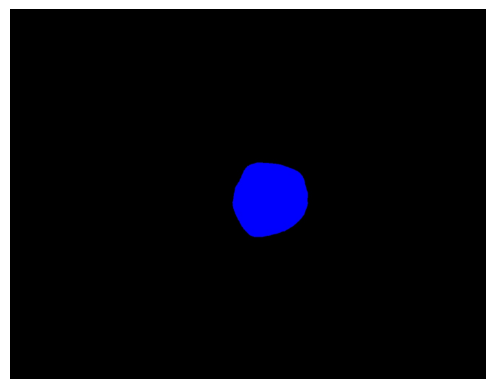

In [40]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

def load_image_as_tensor(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.ToTensor()
    image_tensor = transform(image)
    
    return image_tensor

def visualize_tensor(image_tensor):
    np_image = image_tensor.numpy()
    np_image = np.transpose(np_image, (1, 2, 0))
    plt.imshow(np_image)
    plt.axis('off')
    plt.show()
image_path = '/kaggle/working/predicted_mask/019410b1fcf0625f608b4ce97629ab55.jpeg'
image_tensor = load_image_as_tensor(image_path)
visualize_tensor(image_tensor)


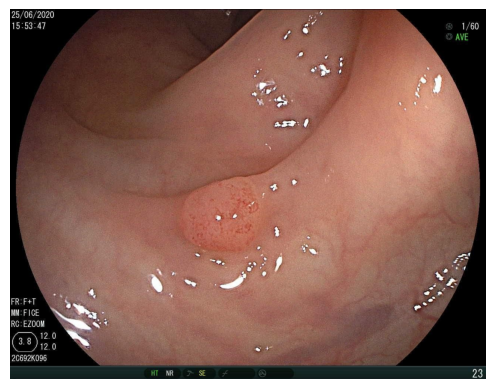

In [41]:
image_path = '/kaggle/input/bkai-igh-neopolyp/test/test/019410b1fcf0625f608b4ce97629ab55.jpeg'
image_tensor = load_image_as_tensor(image_path)
visualize_tensor(image_tensor)



In [ ]:
import numpy as np
import pandas as pd
import cv2
import os

def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 0] = 255
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    return rle_to_string(rle)

def rle2mask(mask_rle, shape=(3,3)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def mask2string(dir):
    ## mask --> string
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
        print(path)
        img = cv2.imread(path)[:,:,::-1]
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r


MASK_DIR_PATH = '' # change this to the path to your output mask folder
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']

df.to_csv(r'output.csv', index=False)

In [42]:
!rm -rf /kaggle/working/output.csv